In [35]:
import matplotlib.patheffects as path_effects
import numpy as np
import pandas as pd

from mplsoccer import Sbopen, Pitch

from variables import player_iden, player_nn, cur_team, comp_name, player_number, player_matches, player_matches_ids

In [36]:
parser = Sbopen()

In [37]:
bins = (16, 12)  # 16 cells x 12 cells

In [38]:
df_match = player_matches
match_ids = player_matches_ids

# next we create a dataframe of all the events
all_events_df = [] #список для событий
cols = ['match_id', 'team_name', 'id', 'type_name', 'sub_type_name', 'player_name', 'player_id',
        'x', 'y', 'end_x', 'end_y', 'outcome_name', 'shot_statsbomb_xg']
for match_id in match_ids:
    # get carries/ passes/ shots
    event = parser.event(match_id)[0]  # get the first dataframe (events) which has index = 0
    event = event.loc[event.type_name.isin(['Carry', 'Shot', 'Pass']), cols].copy() #Собираем данные события по нужным трем

    # boolean columns for working out probabilities
    event['goal'] = event['outcome_name'] == 'Goal'
    event['shoot'] = event['type_name'] == 'Shot'
    event['move'] = event['type_name'] != 'Shot'
    all_events_df.append(event)
event = pd.concat(all_events_df)

In [39]:
event = event[event['team_name'] == cur_team]
event

,match_id,team_name,id,type_name,sub_type_name,player_name,player_id,x,y,end_x,end_y,outcome_name,shot_statsbomb_xg,goal,shoot,move
46,3837876,Paris Saint-Germain,4e96065a-7f6b-4231-be98-811115dd85d5,Pass,Goal Kick,Gianluigi Donnarumma,7036.0,7.0,36.1,63.5,4.7,Incomplete,NaN,False,False,True
50,3837876,Paris Saint-Germain,b3d986e6-ac4c-409e-a011-147c54adb6c5,Pass,Throw-in,Nuno Mendes,41092.0,63.6,0.1,58.5,5.9,NaN,NaN,False,False,True
52,3837876,Paris Saint-Germain,45b59ef0-3d8b-44fa-ac77-4284de6631aa,Carry,NaN,Fabián Ruiz Peña,6655.0,58.5,5.9,57.2,5.2,NaN,NaN,False,False,True
54,3837876,Paris Saint-Germain,c6201979-f51b-4da1-87dc-35395d08165f,Pass,NaN,Fabián Ruiz Peña,6655.0,57.2,5.2,47.1,4.3,NaN,NaN,False,False,True
56,3837876,Paris Saint-Germain,b39bfed8-17bf-46e6-aec5-e6ff73519709,Carry,NaN,Presnel Kimpembe,2999.0,47.1,4.3,45.4,5.3,NaN,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3981,3837662,Paris Saint-Germain,4e5aa655-e635-43e6-be39-08abf6daf4ed,Carry,NaN,Leandro Daniel Paredes,16308.0,55.7,18.2,55.7,18.1,NaN,NaN,False,False,True
3982,3837662,Paris Saint-Germain,37711ff6-6709-4fbc-8d69-c598be75fdfd,Pass,NaN,Leandro Daniel Paredes,16308.0,55.7,18.1,55.4,11.1,NaN,NaN,False,False,True
3984,3837662,Paris Saint-Germain,edb0ec4a-fc06-405a-b55e-0ddd2b90a8f1,Pass,NaN,Neymar da Silva Santos Junior,4320.0,55.4,11.1,53.2,18.9,NaN,NaN,False,False,True
3986,3837662,Paris Saint-Germain,5fc02df8-2e74-42a4-9655-616d20817985,Carry,NaN,Leandro Daniel Paredes,16308.0,53.2,18.9,54.2,23.2,NaN,NaN,False,False,True


In [40]:
pitch = Pitch(line_zorder=2)

In [41]:
shot_probability = pitch.bin_statistic(event['x'], event['y'], values=event['shoot'],
                                       statistic='mean', bins=bins)
move_probability = pitch.bin_statistic(event['x'], event['y'], values=event['move'],
                                       statistic='mean', bins=bins)
goal_probability = pitch.bin_statistic(event.loc[event['shoot'], 'x'],
                                       event.loc[event['shoot'], 'y'],
                                       event.loc[event['shoot'], 'goal'],
                                       statistic='mean', bins=bins)

In [42]:
# get a dataframe of move events and filter it
# so the dataframe only contains actions inside the pitch.
move = event[event['move']].copy()
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
move = move[bin_start_locations['inside']].copy()

# get the successful moves, which filters out the events that ended outside the pitch
# or where not successful (null)
bin_end_locations = pitch.bin_statistic(move['end_x'], move['end_y'], bins=bins)
move_success = move[(bin_end_locations['inside']) & (move['outcome_name'].isnull())].copy()

# get a dataframe of the successful moves
# and the grid cells they started and ended in
bin_success_start = pitch.bin_statistic(move_success['x'], move_success['y'], bins=bins)
bin_success_end = pitch.bin_statistic(move_success['end_x'], move_success['end_y'], bins=bins)
df_bin = pd.DataFrame({'x': bin_success_start['binnumber'][0],
                       'y': bin_success_start['binnumber'][1],
                       'end_x': bin_success_end['binnumber'][0],
                       'end_y': bin_success_end['binnumber'][1]})

# calculate the bin counts for the successful moves, i.e. the number of moves between grid cells
bin_counts = df_bin.value_counts().reset_index(name='bin_counts')

# create the move_transition_matrix of shape (num_y_bins, num_x_bins, num_y_bins, num_x_bins)
# this is the number of successful moves between grid cells.
num_y, num_x = shot_probability['statistic'].shape
move_transition_matrix = np.zeros((num_y, num_x, num_y, num_x))
move_transition_matrix[bin_counts['y'], bin_counts['x'],
                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

# and divide by the starting locations for all moves (including unsuccessful)
# to get the probability of moving the ball successfully between grid cells
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
bin_start_locations = np.expand_dims(bin_start_locations['statistic'], (2, 3))
move_transition_matrix = np.divide(move_transition_matrix,
                                   bin_start_locations,
                                   out=np.zeros_like(move_transition_matrix),
                                   where=bin_start_locations != 0,
                                   )

In [43]:
move_transition_matrix = np.nan_to_num(move_transition_matrix)
shot_probability_matrix = np.nan_to_num(shot_probability['statistic'])
move_probability_matrix = np.nan_to_num(move_probability['statistic'])
goal_probability_matrix = np.nan_to_num(goal_probability['statistic'])

In [44]:
xt = np.multiply(shot_probability_matrix, goal_probability_matrix)
diff = 1
iteration = 0
while np.any(diff > 0.00001):  # iterate until the differences between the old and new xT is small
    xt_copy = xt.copy()  # keep a copy for comparing the differences
    # calculate the new expected threat
    xt = (np.multiply(shot_probability_matrix, goal_probability_matrix) +
          np.multiply(move_probability_matrix,
                      np.multiply(move_transition_matrix, np.expand_dims(xt, axis=(0, 1))).sum(
                          axis=(2, 3)))
          )
    diff = (xt - xt_copy)
    iteration += 1
#print('Number of iterations:', iteration)

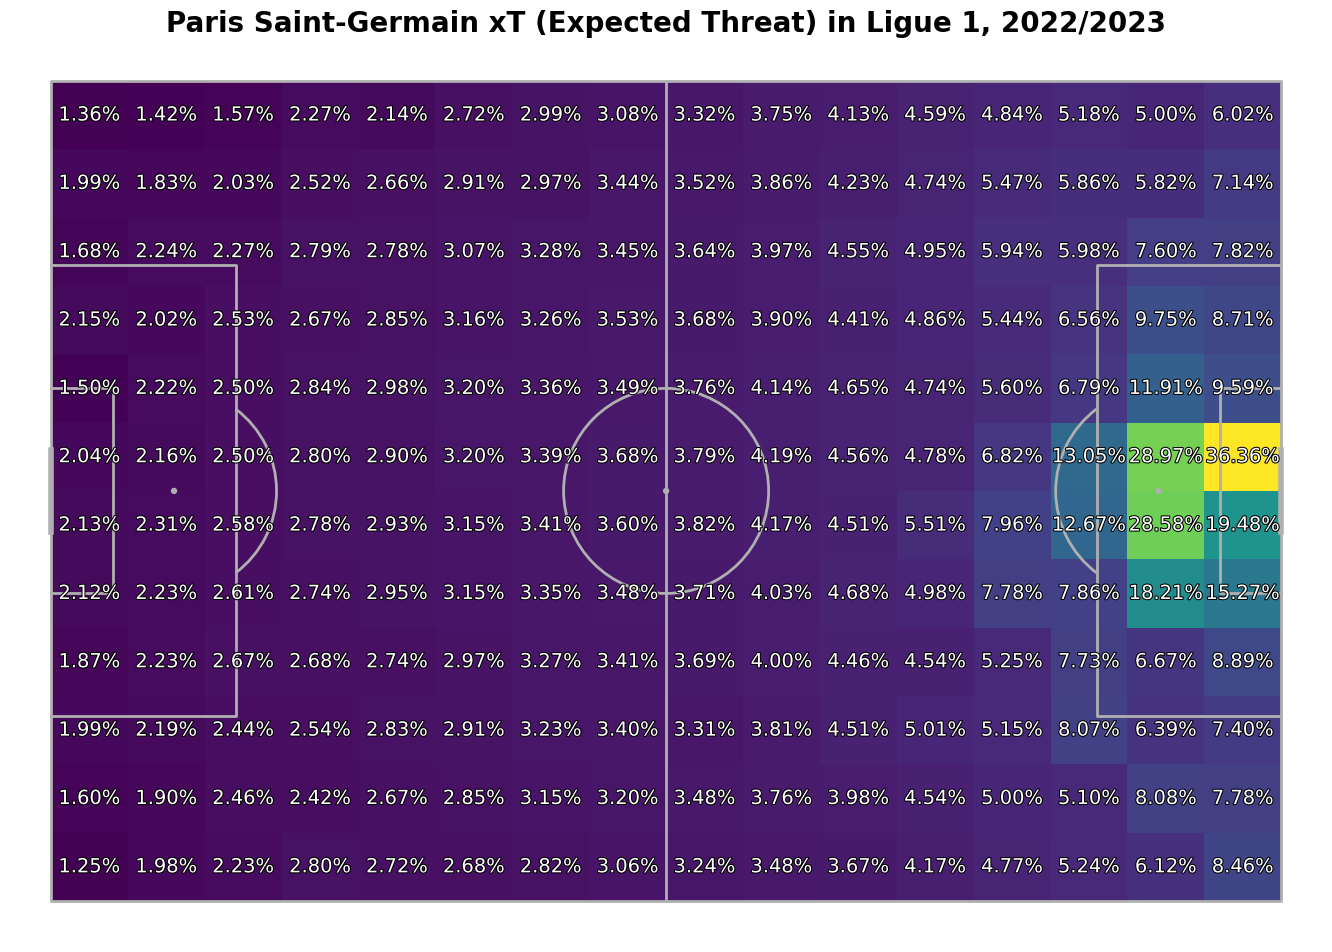

In [45]:
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
# new bin statistic for plotting xt only
for_plotting = pitch.bin_statistic(event['x'], event['y'], bins=bins)
for_plotting['statistic'] = xt
fig, ax = pitch.draw(figsize=(14, 9.625))
_ = pitch.heatmap(for_plotting, ax=ax)
_ = pitch.label_heatmap(for_plotting, ax=ax, str_format='{:.2%}',
                        color='white', fontsize=14, va='center', ha='center',
                        path_effects=path_eff)
ax_title = ax.set_title(f'{cur_team} xT (Expected Threat) in {comp_name}', fontsize=20, fontweight='bold', color='black')

In [46]:
# first get grid start and end cells
grid_start = pitch.bin_statistic(move_success.x, move_success.y, bins=bins)
grid_end = pitch.bin_statistic(move_success.end_x, move_success.end_y, bins=bins)

# then get the xT values from the start and end grid cell
start_xt = xt[grid_start['binnumber'][1], grid_start['binnumber'][0]]
end_xt = xt[grid_end['binnumber'][1], grid_end['binnumber'][0]]

# then calculate the added xT
added_xt = end_xt - start_xt
move_success['xt'] = added_xt

# show players with top 5 total expected threat
df = move_success.groupby('player_name')['xt'].sum().sort_values(ascending=False).reset_index()
df['xt/game'] = df['xt'] / len(match_ids)
df.head(5)

,player_name,xt,xt/game
0,Lionel Andrés Messi Cuccittini,10.604677,0.662792
1,Neymar da Silva Santos Junior,9.257136,0.578571
2,Kylian Mbappé Lottin,5.648115,0.353007
3,Achraf Hakimi Mouh,4.085902,0.255369
4,Nuno Mendes,3.028166,0.189260
